In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import random

# from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras import Sequential
from tensorflow.keras import layers
from tensorflow.keras.utils import image_dataset_from_directory
from Resnet50 import ResNet50

In [2]:
train_ds , val_ds = image_dataset_from_directory('../dataset/small_dataset',
                                        validation_split=0.2,
                                        subset='both',
                                        seed=101,
                                        labels='inferred')


# elem = next(iter(train_ds))
# print(elem[0][0])
classes = train_ds.class_names

Found 3600 files belonging to 50 classes.
Using 2880 files for training.
Using 720 files for validation.


In [3]:
IMG_SIZE = 32

data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal"),
  layers.RandomBrightness(0.2),
  layers.RandomTranslation(0.1,0.3),
  layers.RandomRotation(0.2)
])

resize_and_rescale = Sequential([
  layers.Resizing(IMG_SIZE, IMG_SIZE),
  layers.Rescaling(1./255),
  # layers.Normalization(axis=1, mean=0, variance=1)
])

final_train_ds = train_ds
final_val_ds = val_ds

for i in range(1):
  aug_ds = train_ds.map(lambda x, y: (data_augmentation(x),y))
  final_train_ds = final_train_ds.concatenate(aug_ds)


final_train_ds = final_train_ds.shuffle(buffer_size=320)
final_train_ds = final_train_ds.map(lambda x, y: (resize_and_rescale(x),tf.one_hot(y, depth=len(classes))))
val_ds = val_ds.map(lambda x, y: (resize_and_rescale(x),tf.one_hot(y, depth=len(classes))))



In [4]:
model = ResNet50((IMG_SIZE,IMG_SIZE,3), len(classes))   


model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

model.summary()


Model: "ResNet50"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 32, 32, 3)]          0         []                            
                                                                                                  
 zero_padding2d (ZeroPaddin  (None, 38, 38, 3)            0         ['input_1[0][0]']             
 g2D)                                                                                             
                                                                                                  
 conv1 (Conv2D)              (None, 16, 16, 64)           9472      ['zero_padding2d[0][0]']      
                                                                                                  
 bn_conv1 (BatchNormalizati  (None, 16, 16, 64)           256       ['conv1[0][0]']       

In [5]:
epochs=50
history = model.fit(
  final_train_ds,
  validation_data=val_ds,
  epochs=epochs,
  batch_size=32
)

Epoch 1/50


180/180 [==============================] - 144s 526ms/step - loss: 4.9821 - accuracy: 0.0219 - val_loss: 4.1896 - val_accuracy: 0.0097
Epoch 2/50
180/180 [==============================] - 133s 551ms/step - loss: 4.2855 - accuracy: 0.0318 - val_loss: 4.0567 - val_accuracy: 0.0222
Epoch 3/50
180/180 [==============================] - 130s 536ms/step - loss: 3.9906 - accuracy: 0.0564 - val_loss: 3.8676 - val_accuracy: 0.0528
Epoch 4/50
180/180 [==============================] - 131s 526ms/step - loss: 3.8110 - accuracy: 0.0745 - val_loss: 3.8944 - val_accuracy: 0.0722
Epoch 5/50
180/180 [==============================] - 133s 527ms/step - loss: 3.6802 - accuracy: 0.1030 - val_loss: 3.7785 - val_accuracy: 0.1014
Epoch 6/50
180/180 [==============================] - 139s 540ms/step - loss: 3.5685 - accuracy: 0.1276 - val_loss: 3.9583 - val_accuracy: 0.1167
Epoch 7/50
180/180 [==============================] - 135s 529ms/step - loss: 3.4548 - accuracy: 0.1559 - val_loss: 3.4919

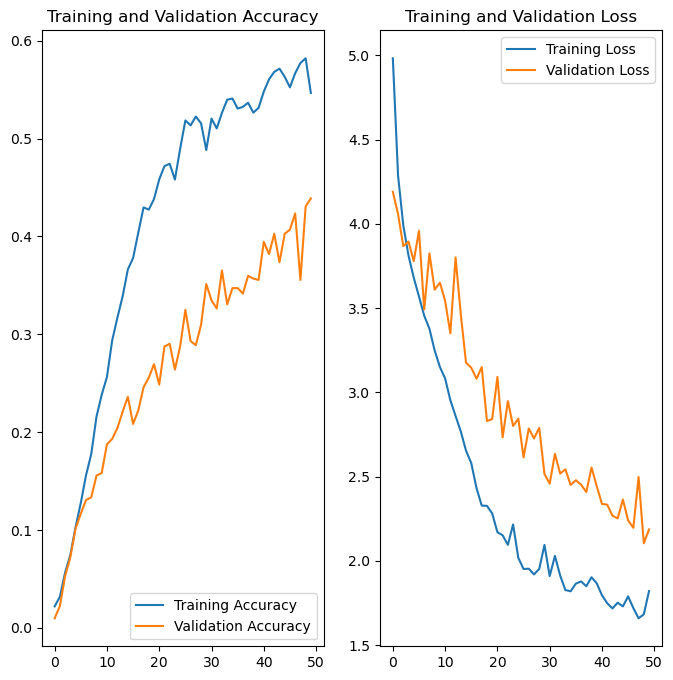

In [8]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [7]:
model.save('resnet50_32.keras')